# Exploring Data on the cluster

This notebook explores how to view geospatial data on the cluster without needing to transfer it

## Imports

In [38]:
import os
import sys
from pathlib import Path
import datetime

import rasterio
from rasterio import plot
from rasterio.plot import show
import matplotlib.pyplot as plt
import shutil
import tempfile
import json
import random
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform
from pyproj import CRS
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from shapely.geometry import Polygon
import xarray as xr

#import /home/klwalker/tmp/geowombatdev/geowombat as gw
#sys.path.append(r"/home/klwalker/tmp/geowombatdev/geowombat")
#from geowombat.geowombat import *
#from geowombat.data import rgbn
#import geowombat as gw

%matplotlib inline

In [20]:
##This is just for data checking. Not actually used in processing sequence so far.
def GetClosestImage(img_dir, imageType, YYYY, DDD):
    '''
    returns path of image closest to day DDD of year YYYY in directory of images
    Currently looks for images with name YYYYDDD* (DDD is day-of-year(1-365))
    or Sentinel images starting with L1C* (Date format is YYYYMMDD, starting at position 19)
    TODO: expand imageType to Landsat
    '''
    
    imgList = []
    
    if imageType == 'TS':
        for img in os.listdir(img_dir):
            if img.startswith(str(YYYY)):
                imgList.append(int(img[4:7]))
    elif imageType == 'L1C':
        for img in os.listdir(img_dir):
            if img.startswith('L1C') and img[19:23]==str(YYYY):
                MM = int(img[23:25])
                DD = int(img[25:27])
                ymd = datetime.datetime(YYYY, MM, DD)
                doy=int(ymd.strftime('%j'))
                imgList.append(doy)
    
    closestDay = min(imgList, key=lambda x:abs(x-DDD))
    print('closest day is: {}'.format(str(YYYY)+str(closestDay)))
    
    for fname in os.listdir(img_dir):
        if imageType == 'TS':
            if str(YYYY)+str(closestDay) in fname:
                closestimg = os.path.join(img_dir,fname)
        elif imageType == 'L1C':
            if str(YYYY)+str(MM)+str(DD) in fname and fname.startswith('L1C') and 'angles' not in fname:
                closestimg = os.path.join(img_dir,fname)
 
    return closestimg

In [40]:
### For visualizing index image (Process check 1)
def exploreBand(img, spec_index):

    print('plotting {} band of image {}'.format(img, spec_index))
    fig, axarr = plt.subplots(1, 3, figsize=(15,5))
    
    if img.endswith('.tif'):
        with rasterio.open(img) as src:
            TSamp = src.read()
    elif img.endswith('.nc'):
        with xr.open_dataset(img) as xrimg:
            #xrcrs = xrimg.rio.crs
            #print(xrcrs)  ##epsg:32632
            #print(xrimg.variables)
            print(xrimg.dims)
            #print(xrimg.coords)
    
        ### Check that x and y values correspond to UTM coords
        print("Coord range is: y: {}-{}. x: {}-{}".format(
          xrimg[spec_index]["y"].values.min(), 
          xrimg[spec_index]["y"].values.max(),
          xrimg[spec_index]["x"].values.min(), 
          xrimg[spec_index]["x"].values.max()))
    
        ### Get single band (Opens as Dataset)
        xr_idx = xrimg[spec_index]
    
        ##Note outliers (while nodata = None)
        origHist = xr_idx.plot.hist(color="purple")
        #ax.imshow()
        
        xr_idx_clean = xr_idx.where(xr_idx < 10000)
        maskedHist = xr_idx_clean.plot.hist(color="purple")
        #print('The no data value is:', xrimg[spec_index].rio.nodata)
    
        TSamp = xr_idx_clean

    if img.endswith('.nc'):
        xr_idx.plot.hist(color="purple",  ax=axarr[0])
        axarr[0].set_title("original data")
        xr_idx_clean.plot.hist(color="purple", ax=axarr[1])
        axarr[1].set_title("masked data")
        TSamp.plot(x="x",y="y")
        plot.show(TSamp, ax=axarr[2])
        axarr[2].set_title('{} band'.format(spec_index))
        axarr[2].axis('off')
    
    elif img.endswith('.tif'):
        plot.show(TSamp)
        axarr[2].set_title('{} band'.format(spec_index))
        axarr[2].axis('off')
        
    return axarr

In [41]:
evi_dir = Path("/home/downspout-cel/chile_lc/raster/grids/001157/brdf_ts/ms/evi2")
raw_dir = Path("/home/sandbox-cel/chile_lc/raster/grids/001157/brdf")

closest day is: 2018249
plotting /home/sandbox-cel/chile_lc/raster/grids/001157/brdf/L1C_T18HXE_A009274_20181215T144702_MTD.nc band of image nir
Frozen(SortedKeysDict({'y': 666, 'x': 666}))
Coord range is: y: -620865.0150150341--600865.015015015. x: -1141104.984984985--1121104.9849849658


array([<AxesSubplot:title={'center':'original data'}, xlabel='nir'>,
       <AxesSubplot:title={'center':'masked data'}, xlabel='nir'>,
       <AxesSubplot:title={'center':'nir band'}, xlabel='x', ylabel='y'>],
      dtype=object)

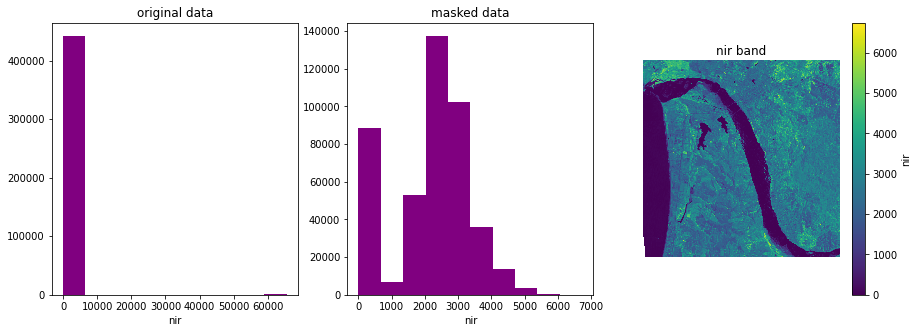

In [42]:
#SampImg_evi = GetClosestImage(evi_dir,'TS',2018,250)
SampImg_raw = GetClosestImage(raw_dir,'L1C',2018,250)
exploreBand(SampImg_raw, 'nir')

## Plot 3-band image

<xarray.DataArray 'red' ()>
array(10.) <xarray.DataArray 'red' ()>
array(5636.)


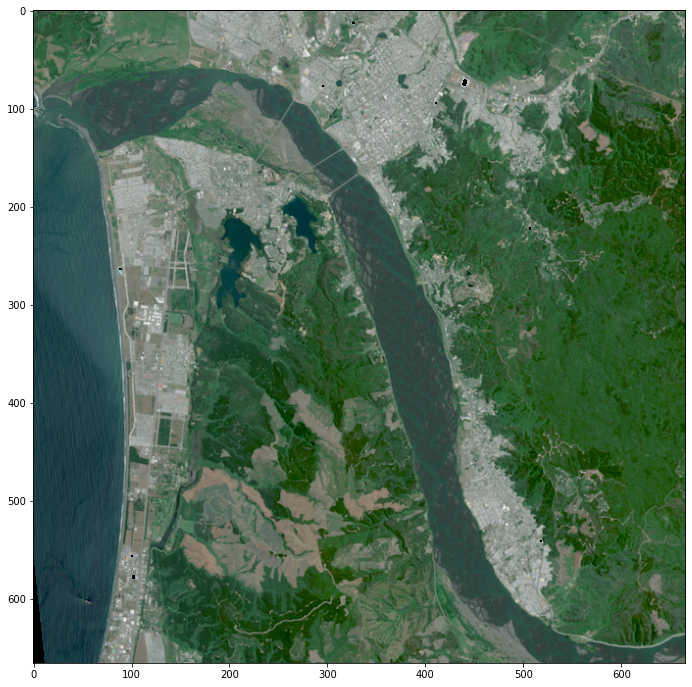

In [72]:
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

def gammacorr(band):
    gamma=3
    return np.power(band, 1/gamma)

with xr.open_dataset(SampImg_raw) as xrimg:
    red = xrimg['red'].where(xrimg['red'] != 65535)
    green = xrimg['green'].where(xrimg['green'] != 65535)
    blue = xrimg['blue'].where(xrimg['blue'] != 65535)
    print (red.min(), red.max())
    

red_g=gammacorr(red)
blue_g=gammacorr(blue)
green_g=gammacorr(green)

red_norm_g = normalize(red_g)
green_norm_g = normalize(green_g)
blue_norm_g = normalize(blue_g)

rgb = np.dstack([red_norm_g, green_norm_g, blue_norm_g])
fig = plt.figure(figsize=(18,12))
plt.imshow(rgb)